In [1]:
library(tidyverse)
library(repr)
library(tidymodels)
library(readxl)
set.seed(9999)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.2     ✔ purrr   0.3.4
✔ tibble  3.0.3     ✔ dplyr   1.0.2
✔ tidyr   1.1.2     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.5.0

Warning message:
“package ‘ggplot2’ was built under R version 4.0.1”
Warning message:
“package ‘tibble’ was built under R version 4.0.2”
Warning message:
“package ‘tidyr’ was built under R version 4.0.2”
Warning message:
“package ‘dplyr’ was built under R version 4.0.2”
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Warning message:
“package ‘tidymodels’ was built under R version 4.0.2”
── Attaching packages ────────────────────────────────────── tidymodels 0.1.1 ──

✔ broom     0.7.0      ✔ recipes   0.1.13
✔ dials     0.0.9      ✔ rsample   0.0.7 
✔ infer     0.5.4      ✔ tune      0.1.1 
✔ modeldata 0.0.2      ✔ workflows 0.2.0 
✔ parsnip   0.1.3    

# Project Proposal: Predicting Credit Card Default Through Loan Repayment Data

## Introduction:

When banks give loans to clients, they do so with the expectation that the credit card loan will be repaid in full with interest. It can be difficult to predict whether a client will pay in full or default on their payments, therefore we are hoping to use the [“default of credit card clients Data Set” from the UCI Machine Learning Repository](http://archive.ics.uci.edu/ml/datasets/default+of+credit+card+clients) to see if we can predict if a potential client will default on their credit card. **We are asking whether a bank can predict when a person will default on their credit card loans based on previous payment history.**

## Methods: 

The dataset used in this project consists of information on credit card users in Taiwan. It includes demographic information such as age, sex and marital status, as well as loan repayment history for April to September 2005. The table below is a small sample of the dataset. There are a total of 3,000 individual records displaying 25 variables, consisting mostly of loan bills and payments. 



In [2]:
df_default <- read_csv('https://github.com/jorosafi/dsci-group-project/blob/main/data/cc-defaults.csv?raw=true')
head(df_default)

Warning message:
“Missing column names filled in: 'X1' [1]”
Warning message:
“Duplicated column names deduplicated: 'X1' => 'X1_1' [2]”
Parsed with column specification:
cols(
  .default = col_character()
)

See spec(...) for full column specifications.



X1,X1_1,X2,X3,X4,X5,X6,X7,X8,X9,⋯,X15,X16,X17,X18,X19,X20,X21,X22,X23,Y
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,⋯,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,⋯,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
1,20000,2,2,1,24,2,2,-1,-1,⋯,0,0,0,0,689,0,0,0,0,1
2,120000,2,2,2,26,-1,2,0,0,⋯,3272,3455,3261,0,1000,1000,1000,0,2000,1
3,90000,2,2,2,34,0,0,0,0,⋯,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
4,50000,2,2,1,37,0,0,0,0,⋯,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
5,50000,1,2,1,57,-1,0,-1,0,⋯,20940,19146,19131,2000,36681,10000,9000,689,679,0


We will use the loan amount and repayment history to attempt to predict whether a credit card user will default on their credit card loan through a K nearest neighbour classification model. The repayment information variables will be our predictors and the default status will be the response variable. 

To tidy the data we removed variables we are not using, such as sex and marital status, and created new columns to summarize the repayment history over the study period. We also added clear and readable column names. Below is a small sample of the tidy dataset. 


In [3]:
df_default_tidy <- df_default %>%
    select(-c(X2:X11))%>%
    rename(client_id = "X1", 
           balance_limit = X1_1,
           sep_bill = X12 , 
           aug_bill= X13 ,
           july_bill= X14,
           june_bill= X15,
           may_bill= X16, 
           april_bill=X17,
           sep_paid= X18 ,
           aug_paid= X19, 
           july_paid= X20, 
           june_paid= X21 ,
           may_paid= X22 ,
           april_paid= X23,
           default_status = Y)%>%
    slice(2:30001) %>%
    mutate_if(is.character, as.numeric) %>%
    mutate(client_id = as.character(client_id),
           default_status = case_when(default_status =="1"~"yes",
                                     default_status== "0"~"no"),
           default_status = as.factor(default_status),
           average_bill = (sep_bill + aug_bill + july_bill + june_bill + may_bill +april_bill)/6,
           average_paid = (sep_paid + aug_paid + july_paid + june_paid + may_paid +april_paid)/6,
           total_bill = sep_bill + aug_bill + july_bill + june_bill + may_bill +april_bill,
           total_paid = sep_paid + aug_paid + july_paid + june_paid + may_paid +april_paid)

head(df_default_tidy)

client_id,balance_limit,sep_bill,aug_bill,july_bill,june_bill,may_bill,april_bill,sep_paid,aug_paid,july_paid,june_paid,may_paid,april_paid,default_status,average_bill,average_paid,total_bill,total_paid
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>
1,20000,3913,3102,689,0,0,0,0,689,0,0,0,0,yes,1284.000,114.8333,7704,689
2,120000,2682,1725,2682,3272,3455,3261,0,1000,1000,1000,0,2000,yes,2846.167,833.3333,17077,5000
3,90000,29239,14027,13559,14331,14948,15549,1518,1500,1000,1000,1000,5000,no,16942.167,1836.3333,101653,11018
4,50000,46990,48233,49291,28314,28959,29547,2000,2019,1200,1100,1069,1000,no,38555.667,1398.0000,231334,8388
5,50000,8617,5670,35835,20940,19146,19131,2000,36681,10000,9000,689,679,no,18223.167,9841.5000,109339,59049
6,50000,64400,57069,57608,19394,19619,20024,2500,1815,657,1000,1000,800,no,39685.667,1295.3333,238114,7772


**Spliting the data**

In [11]:
default_split <- initial_split(df_default_tidy, prop = 0.75, strata = default_status) 
default_train <- training(default_split)
default_test <- testing(default_split)

head(default_train)
head(default_test)

client_id,balance_limit,sep_bill,aug_bill,july_bill,june_bill,may_bill,april_bill,sep_paid,aug_paid,july_paid,june_paid,may_paid,april_paid,default_status,average_bill,average_paid,total_bill,total_paid
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>
1,2e+04,3913,3102,689,0,0,0,0,689,0,0,0,0,yes,1284.00,114.8333,7704,689
3,9e+04,29239,14027,13559,14331,14948,15549,1518,1500,1000,1000,1000,5000,no,16942.17,1836.3333,101653,11018
4,5e+04,46990,48233,49291,28314,28959,29547,2000,2019,1200,1100,1069,1000,no,38555.67,1398.0000,231334,8388
5,5e+04,8617,5670,35835,20940,19146,19131,2000,36681,10000,9000,689,679,no,18223.17,9841.5000,109339,59049
6,5e+04,64400,57069,57608,19394,19619,20024,2500,1815,657,1000,1000,800,no,39685.67,1295.3333,238114,7772
7,5e+05,367965,412023,445007,542653,483003,473944,55000,40000,38000,20239,13750,13770,no,454099.17,30126.5000,2724595,180759


client_id,balance_limit,sep_bill,aug_bill,july_bill,june_bill,may_bill,april_bill,sep_paid,aug_paid,july_paid,june_paid,may_paid,april_paid,default_status,average_bill,average_paid,total_bill,total_paid
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>
2,120000,2682,1725,2682,3272,3455,3261,0,1000,1000,1000,0,2000,yes,2846.167,833.3333,17077,5000
9,140000,11285,14096,12108,12211,11793,3719,3329,0,432,1000,1000,1000,no,10868.667,1126.8333,65212,6761
12,260000,12261,21670,9966,8517,22287,13668,21818,9966,8583,22301,0,3640,no,14728.167,11051.3333,88369,66308
13,630000,12137,6500,6500,6500,6500,2870,1000,6500,6500,6500,2870,0,no,6834.500,3895.0000,41007,23370
15,250000,70887,67060,63561,59696,56875,55512,3000,3000,3000,3000,3000,3000,no,62265.167,3000.0000,373591,18000
16,50000,50614,29173,28116,28771,29531,30211,0,1500,1100,1200,1300,1100,no,32736.000,1033.3333,196416,6200


To do an initial exploration of the data, we created a scatter plot to see if there was any clear visual relationship between payment history and the likelihood of defaulting on a payment. The plot below plots the total amount billed to clients versus the total paid by clients over the period of the study to see if there is any relationship between payment history and defaulting on loans. 

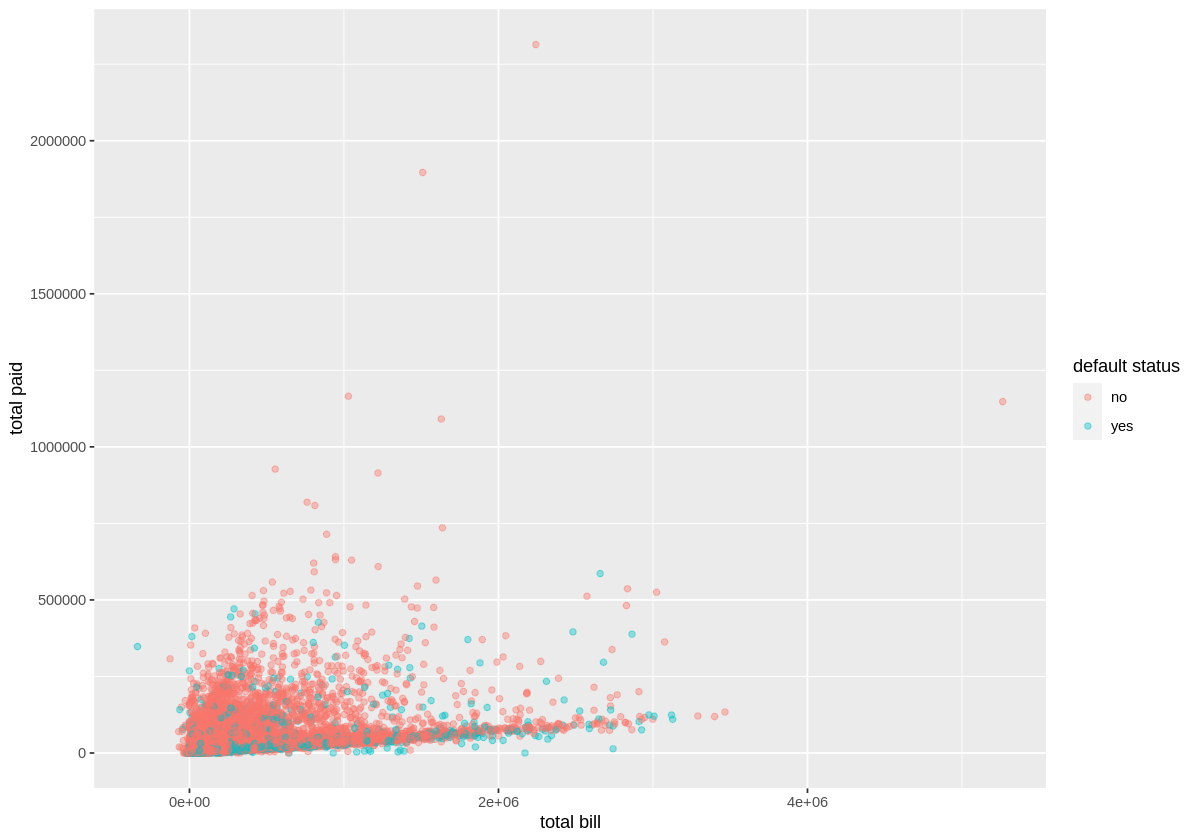

In [9]:
options(repr.plot.length = 20)
options(repr.plot.width = 10)

sep_bill_plot = ggplot(default_train, aes(x = total_bill, y = total_paid, colour = default_status)) +
geom_point(alpha = 0.4)+
labs(x = "total bill", y = "total paid",colour = "default status")
sep_bill_plot

## Expected outcomes and significance:
We expect the model to be able to predict the likelihood of a credit card user defaulting on their loans based on the previous bill payments. Our hypothesis is that the more missed or incomplete payments a credit card user has, the more likely they are to default on their payments the following month. 

While our model may not be complex enough for a large financial institution, this kind of prediction is important for banks and other creditors to be able to manage risk when analyzing loan applications. This type of model can have a big impact on both financial institutions and customers looking for loans. 

## Future questions
Given the importance that access to loans has for people and financial institutions it is crucial that these models accurately predict the possibility of default without perpetuating existing forms of discrimination. For this reason, other factors need to be considered to improve the model from a financial risk perspective, but also through an equity lens to prevent the perpetuation of implicit and explicit systems of oppression.
